In [36]:
# import helper
import pandas as pd
from utils import *
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch import nn
from IPython.display import Image
import torch
from torch import nn
from torch.utils.data import Dataset
import pennylane as qml
import torch.optim as optim
import torch.utils.data as data
import random
import tensorflow as tf

In [37]:
tf.random.set_seed(15)
torch.manual_seed(42)
random.seed(42)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({'font.size':20})
legend_prop = {'weight':'bold'}
from pylab import rcParams
rcParams['axes.linewidth'] = 2

## Data : We use the same data as used on Classical solutions

In [38]:
df = pd.read_csv('Processed_data.csv')
df = df.drop([ 'Unnamed: 0'], axis=1)
# Initial dataframe has few rows which has zeros for features like "SMA_7" etc and hence removing few top rows
df=df[50:]
df.tail(10)

,Open,High,Low,Close,Volume,Date,EMA_7,EMA_14,EMA_21,SMA_7,...,3M,FTSE_H-L,FTSE_O-C,GBP_USD_H-L,GBP_USD_O-C,Gold_H-L,Gold_O-C,Crude_H-L,Crude_O-C,Close_copy
3248,7711.71,7733.54,7692.48,7728.50,5.750400e+08,2024-02-19,7642.331920,7620.773180,7613.327011,7609.241429,...,5.3288,41.06,-16.79,0.004641,0.000000,0.0,0.0,1.04,-0.01,7728.50
3249,7728.50,7748.73,7705.98,7719.21,8.190300e+08,2024-02-20,7661.551440,7633.898090,7622.952737,7630.188571,...,5.3290,42.75,9.29,0.008685,0.000063,13.4,-11.9,1.58,0.96,7719.21
3250,7719.21,7719.21,7642.75,7662.51,1.190000e+09,2024-02-21,7661.791080,7637.713011,7626.548852,7642.877143,...,5.3270,76.46,56.70,0.003393,-0.000096,5.9,5.9,1.50,-0.47,7662.51
3251,7662.51,7702.86,7651.65,7684.49,1.320000e+09,2024-02-22,7667.465810,7643.949943,7631.816229,7667.478571,...,5.3285,51.21,-21.98,0.009714,0.000080,13.5,13.5,1.63,-0.51,7684.49
3252,7684.49,7713.39,7675.19,7706.28,9.929600e+08,2024-02-23,7677.169357,7652.260617,7638.585663,7687.175714,...,5.3307,38.20,-21.79,0.005206,-0.000225,23.7,-12.6,2.04,1.80,7706.28
3253,7706.28,7710.78,7676.75,7684.30,1.150000e+09,2024-02-26,7678.952018,7656.532535,7642.741512,7699.571429,...,5.3292,34.03,21.98,0.004227,-0.000161,10.6,5.6,2.04,-0.94,7684.30
3254,7684.30,7698.29,7669.71,7683.02,1.060000e+09,2024-02-27,7679.969014,7660.064197,7646.403193,7695.472857,...,5.3300,28.58,1.28,0.003499,0.000000,1.9,1.9,1.64,-1.10,7683.02
3255,7683.02,7693.18,7620.37,7624.98,1.150000e+09,2024-02-28,7666.221760,7655.386304,7644.455630,7680.684286,...,5.3291,72.81,58.04,0.005957,-0.000096,12.2,-3.5,1.68,-0.28,7624.98
3256,7624.98,7677.69,7622.87,7630.02,1.870000e+09,2024-02-29,7657.171320,7652.004130,7643.143300,7667.942857,...,5.3291,54.82,-5.04,0.005302,-0.000113,15.5,-11.4,0.70,0.03,7630.02
3257,7630.02,7695.61,7630.02,7688.38,1.220000e+09,2024-03-01,7664.973490,7656.854246,7647.255727,7671.638571,...,5.3278,65.59,-58.36,0.005503,0.000175,45.1,-43.8,2.54,-1.58,7688.38


In [39]:
# Remove few redundant data
df=df.drop(columns=['Date'])
df=df.drop(columns=['CUMLOGRET_1'])
df=df.drop(columns=['Gold in USD volume'])
df=df.drop(columns=['Open'])
df=df.drop(columns=['High'])
df=df.drop(columns=['Low'])

In [40]:
# Set target and features
target = "Close"
features = list(df.columns.difference(["Close"]))
print(features)
print(len(features))

['3M', 'BBB_20_2.0', 'BBL_20_2.0', 'BBM_20_2.0', 'BBP_20_2.0', 'BBU_20_2.0', 'Close_copy', 'Crude Futures_close', 'Crude Futures_volume', 'Crude_H-L', 'Crude_O-C', 'EMA_14', 'EMA_21', 'EMA_7', 'FTSE_H-L', 'FTSE_O-C', 'GBP USD ', 'GBP_USD_H-L', 'GBP_USD_O-C', 'Gold in USD close', 'Gold_H-L', 'Gold_O-C', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'SMA_14', 'SMA_21', 'SMA_7', 'Volume']
29


In [41]:
target_mean = df[target].mean()
target_stdev = df[target].std()

for c in df.columns:
    mean = df[c].mean()
    stdev = df[c].std()

    df[c] = (df[c] - mean) / stdev

In [42]:
sequence_length = 60
window =10

def create_dataset(dataset,target,features, lookback, window):
    X_store, y_store = [], []
    for i in range(0,len(dataset)-lookback-window,2):
        X = (dataset[features].values)[i:i+lookback]
        y = (dataset[target].values)[i+lookback:i+lookback+window]
        X_store.append(X)
        y_store.append(y)
    return np.array(X_store), np.array(y_store)

In [43]:
# Split train test data
from sklearn.model_selection import train_test_split
# df_train, df_test = train_test_split(df, test_size=0.05)
size=int(len(df))-10
df_train=df[:size]
df_test=df[size:]
print('Total sample', len(df))
print('Train sample', len(df_train))
print('Test sample', len(df_test))

Total sample 3208
Train sample 3198
Test sample 10


In [44]:
# Train data
X_train, y_train = create_dataset(
    df_train,
    target=target,
    features=features,
    lookback=sequence_length, window=window)

indices = tf.range(start=0, limit=tf.shape(X_train)[0])
shuffled_indices = tf.random.shuffle(indices)
X_train = tf.gather(X_train, shuffled_indices)
y_train = tf.gather(y_train, shuffled_indices)

print(X_train.shape, y_train.shape)

(1564, 60, 29) (1564, 10)


# Proposed Approach

In [45]:
from tensorflow.keras import regularizers, initializers
from keras.layers import Input, Dense, Reshape, Embedding, concatenate, Dropout, Flatten
from keras.layers.merge import Dot
from keras.preprocessing import sequence
from keras import Model
from keras.layers.advanced_activations import PReLU
import tensorflow as tf

In [46]:
input_ = Input((60,29)) # feature
print(input_.shape)
den1=Dense(20, use_bias=True,activation=PReLU() )(input_)
print(den1.shape)
den2=Flatten()(den1)
print(den2.shape)
den3=Dense(96, use_bias=True,activation=PReLU()  )(den2)
print(den3.shape)
den4=Dense(64, use_bias=True,activation=PReLU()  )(den3)
print(den4.shape)
den5=Dense(10, use_bias=True,activation=PReLU() )(den4)
print(den5.shape)
model = Model(inputs=[input_], outputs=den5)

(None, 60, 29)
(None, 60, 20)
(None, 1200)
(None, 96)
(None, 64)
(None, 10)


In [47]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 29)]          0         
                                                                 
 dense_4 (Dense)             (None, 60, 20)            1800      
                                                                 
 flatten_1 (Flatten)         (None, 1200)              0         
                                                                 
 dense_5 (Dense)             (None, 96)                115392    
                                                                 
 dense_6 (Dense)             (None, 64)                6272      
                                                                 
 dense_7 (Dense)             (None, 10)                660       
                                                                 
Total params: 124,124
Trainable params: 124,124
Non-trainab

In [48]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(opt, loss=loss_fn)

In [49]:
model_history = model.fit(X_train, y_train,
#                     validation_data=(X_test, y_test),
                   batch_size=5, 
                   epochs=400, shuffle=True
                   )

Epoch 1/400
313/313 [==============================] - 3s 4ms/step - loss: 0.2488
Epoch 2/400
313/313 [==============================] - 1s 4ms/step - loss: 0.0694
Epoch 3/400
313/313 [==============================] - 1s 4ms/step - loss: 0.0559
Epoch 4/400
313/313 [==============================] - 1s 4ms/step - loss: 0.0429
Epoch 5/400
313/313 [==============================] - 1s 4ms/step - loss: 0.0381
Epoch 6/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0335
Epoch 7/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0303
Epoch 8/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0253
Epoch 9/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0223
Epoch 10/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0199
Epoch 11/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0187
Epoch 12/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0177
Epoch 13/400


313/313 [==============================] - 1s 3ms/step - loss: 0.0014
Epoch 196/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0016
Epoch 197/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0015
Epoch 198/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0021
Epoch 199/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0026
Epoch 200/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0036
Epoch 201/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0021
Epoch 202/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0013
Epoch 203/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0018
Epoch 204/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 205/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0017
Epoch 206/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0020
Epoch 

313/313 [==============================] - 1s 3ms/step - loss: 0.0015
Epoch 389/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0011
Epoch 390/400
313/313 [==============================] - 1s 3ms/step - loss: 9.2652e-04
Epoch 391/400
313/313 [==============================] - 1s 3ms/step - loss: 8.5388e-04
Epoch 392/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0011
Epoch 393/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0011
Epoch 394/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0018
Epoch 395/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 396/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0016
Epoch 397/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0015
Epoch 398/400
313/313 [==============================] - 1s 3ms/step - loss: 0.0015
Epoch 399/400
313/313 [==============================] - 1s 3ms/step - loss: 0.001

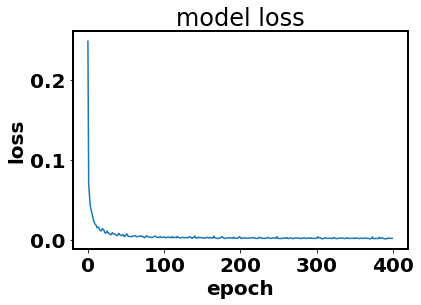

In [50]:
import keras
from matplotlib import pyplot as plt
plt.plot(model_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [51]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
def cal_metrics(y_true,y_pred):
    mae=0
    rmse=0
    for i in range(len(y_true)):
        y1=y_true[i]* target_stdev + target_mean
        y2=y_pred[i]* target_stdev + target_mean
        mae=mean_absolute_error(y1, y2)+mae
        rmse=mean_squared_error(y1, y2, squared=False)+rmse  
    return mae/len(y_true) , rmse/len(y_true)

In [52]:
def mae_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        sum_error += abs(predicted[i] - actual[i])
    return sum_error/len(actual)

def rmse_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        sum_error += (predicted[i] - actual[i])**2
    return (sum_error/len(actual))**0.5

In [53]:
mae_train_pros, rmse_train_pros= cal_metrics(y_train,model.predict(X_train))
print('MAE train error is',mae_train_pros)
print('RMSE train error is',rmse_train_pros)

MAE train error is 19.394965893991813
RMSE train error is 23.52175012969324


In [54]:
# The unknown data
X_check=(df_train[features].values)[len(df_train)-sequence_length:len(df_train)]
y_check=(df_test[target].values)[:window]

In [55]:
y_ann_pred = model.predict(np.array([X_check]))
x1=y_ann_pred*target_stdev + target_mean
x2=y_check*target_stdev + target_mean

In [56]:
x1[0]

array([7653.999 , 7685.2046, 7664.0127, 7611.0337, 7735.5273, 7729.0933,
       7645.175 , 7653.427 , 7629.095 , 7627.7607], dtype=float32)

In [57]:
x2

array([7728.5 , 7719.21, 7662.51, 7684.49, 7706.28, 7684.3 , 7683.02,
       7624.98, 7630.02, 7688.38])

In [58]:
print('MAE Error',mae_metric(x1[0], x2) )
print('RMSE error',rmse_metric(x1[0], x2) )

MAE Error 38.53419921875011
RMSE error 45.69870970774384


In [59]:
from datetime import datetime, date, timedelta
start='2024-02-19'
start = datetime.strptime(start, '%Y-%m-%d')
end= start + timedelta(days=13)
# first create a DataFrame with all dates between specified start<-->end using pd.date_range()
all_dates = pd.DataFrame(pd.date_range(start, end,freq='B').date, columns=['Date'])

In [60]:
all_dates

,Date
0,2024-02-19
1,2024-02-20
2,2024-02-21
3,2024-02-22
4,2024-02-23
5,2024-02-26
6,2024-02-27
7,2024-02-28
8,2024-02-29
9,2024-03-01


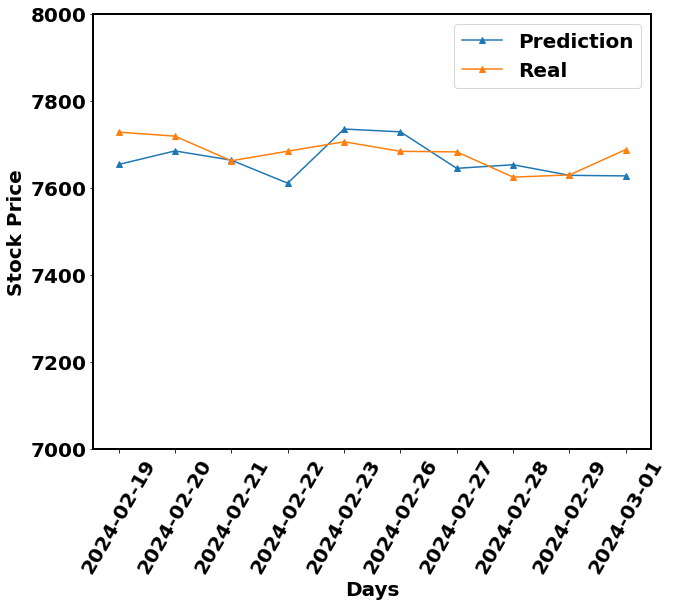

In [61]:
plt.figure(figsize=(10, 8))
plt.plot( x1[0], label = "Prediction",marker='^')
plt.plot( x2, label = "Real",marker='^')
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.xticks(list(range(10)), all_dates['Date'].values)
plt.xticks(rotation=60)
plt.ylim(7000, 8000) 
plt.legend()
plt.show()

In [62]:
def accuracy(y_true, y_pred, threshold):
    c=0
    for i in range(len(y_true)):
        if abs(y_true[i]-y_pred[i])<threshold:
            c=c+1
    return c/len(y_true)

In [63]:
accuracy(x1[0], x2,80)

1.0

# From 1st to 15th march

In [64]:
df.tail()

,Close,Volume,EMA_7,EMA_14,EMA_21,SMA_7,SMA_14,SMA_21,MACD_12_26_9,MACDh_12_26_9,...,3M,FTSE_H-L,FTSE_O-C,GBP_USD_H-L,GBP_USD_O-C,Gold_H-L,Gold_O-C,Crude_H-L,Crude_O-C,Close_copy
3253,1.325103,1.388230,1.328815,1.304880,1.293290,1.358115,1.270862,1.278446,0.336362,0.435002,...,3.028234,-0.945847,0.365122,-0.332766,-0.539417,-0.362193,0.438948,0.102523,-0.706532,1.325103
3254,1.323079,1.050955,1.330434,1.310537,1.299185,1.351608,1.277042,1.282277,0.332469,0.339126,...,3.028804,-1.061538,0.034485,-0.375278,0.078090,-1.088165,0.145689,-0.198538,-0.828195,1.323079
3255,1.231306,1.388230,1.308550,1.303044,1.296050,1.328127,1.280402,1.279128,0.250937,0.077415,...,3.028163,-0.122631,0.941101,-0.231739,-0.290113,-0.228682,-0.282310,-0.168432,-0.204670,1.231306
3256,1.239275,4.086433,1.294142,1.297627,1.293937,1.307896,1.286943,1.279086,0.189730,-0.083522,...,3.028163,-0.504520,-0.066463,-0.269989,-0.355316,0.046687,-0.908457,-0.906031,0.031054,1.239275
3257,1.331555,1.650556,1.306563,1.305395,1.300558,1.313764,1.300004,1.284132,0.212954,-0.011073,...,3.027237,-0.275896,-0.918132,-0.258251,0.749293,2.516657,-3.476452,0.478849,-1.193186,1.331555


In [65]:
X_1_15=(df[features].values)[len(df)-sequence_length:len(df)]

In [66]:
y_1_15 = model.predict(np.array([X_1_15]))

In [67]:
y_1_15[0]*target_stdev + target_mean

array([7820.2   , 7679.6704, 7628.637 , 7609.003 , 7611.697 , 7675.2144,
       7797.661 , 7779.1353, 7739.823 , 7673.7397], dtype=float32)

In [68]:
from datetime import datetime, date, timedelta
start='2024-03-4'
start = datetime.strptime(start, '%Y-%m-%d')
end= start + timedelta(days=13)
# first create a DataFrame with all dates between specified start<-->end using pd.date_range()
all_dates = pd.DataFrame(pd.date_range(start, end,freq='B').date, columns=['Date'])

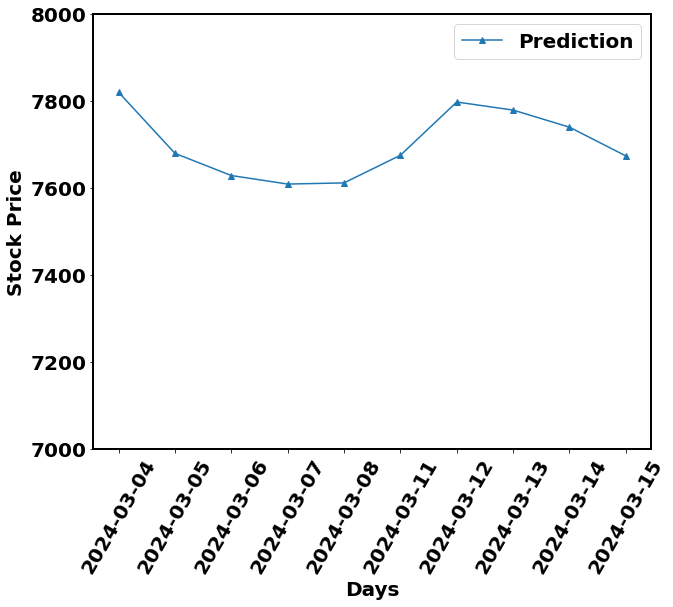

In [69]:
plt.figure(figsize=(10, 8))
plt.plot( y_1_15[0]*target_stdev + target_mean, label = "Prediction",marker='^')
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.xticks(list(range(10)), all_dates['Date'].values)
plt.xticks(rotation=60)
plt.ylim(7000, 8000) 
plt.legend()
plt.show()